In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
#libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import collections

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [3]:
#read data
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- input features : time, amount, V1-V28 PCA components of features - cant be revealed due to compliance
- output: class 0- no fraud, 1-fraud

Concepts for fraud:

- Fraud Transaction Patterns:
    - High transaction amounts.
    - Rapid transactions in short time frames.
    - Transactions from unusual locations (IP or physical).
- Anomalous Merchant/Category: Certain merchants or categories may have higher fraud rates.
- Imbalanced Data:
    - Fraudulent transactions form a small fraction (often <1%) of all transactions.
    - Requires techniques like oversampling (SMOTE) or anomaly detection.
- Regulatory Compliance:GDPR and PCI-DSS standards for handling credit card data. Ensure privacy and secure storage.

Workflow Notes

EDA:
- correlation
- distribution of features

Preprocessing:
- Handling missing values
- scale and normalize values
- split data train and test

Feature Engineering:
- class imbalance: undersample/oversample
- dimensionality reduction

Train Model
- try different ml models

#### EDA

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
#missing 
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Null Values:

No null values to process

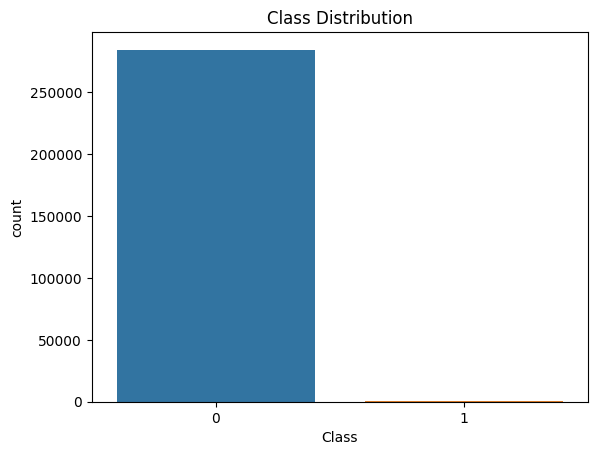

In [6]:
#class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

In [7]:
len(df[df['Class'] == 1]) , len(df[df['Class'] == 0])

(492, 284315)

In [8]:
df.corr()['Class']

Time     -0.012323
V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

Distribution of Amount and time for fraud and non-fraud transactions

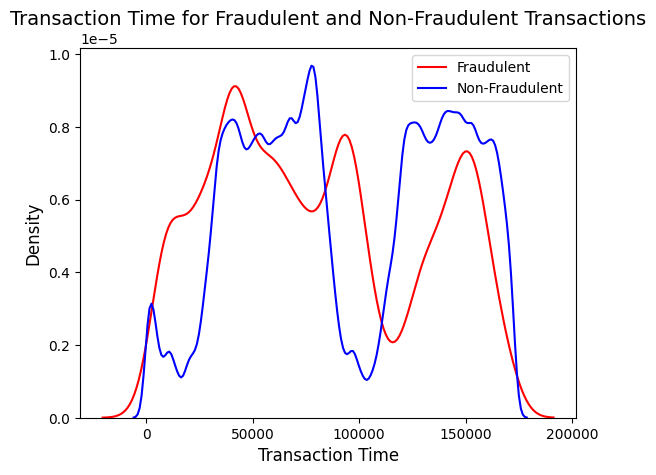

In [9]:
#time with fraud and non fraud
fraud = df.loc[df['Class'] == 1]
non_fraud = df.loc[df['Class'] == 0]
sns.kdeplot(fraud['Time'], label='Fraudulent', color='red', bw_adjust=0.5, fill=False)
sns.kdeplot(non_fraud['Time'], label='Non-Fraudulent', color='blue', bw_adjust=0.5, fill=False)
plt.xlabel('Transaction Time', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Transaction Time for Fraudulent and Non-Fraudulent Transactions', fontsize=14)
plt.legend()
plt.show()

With time, there does not seem to be a distinctive pattern for fraud transactions. So, maybe we can drop Time from our data.

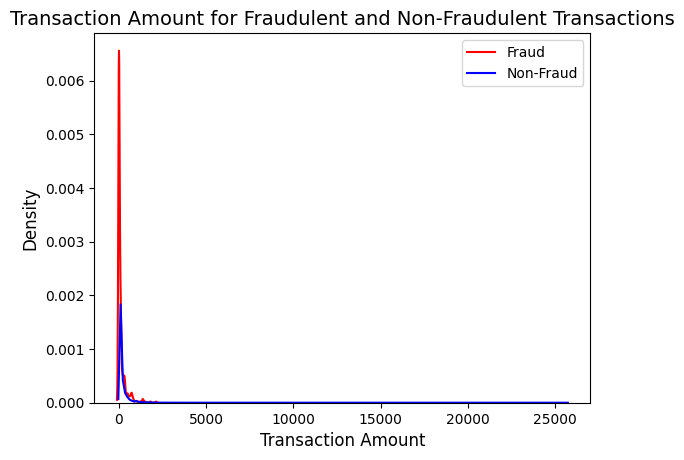

In [10]:
#Amount for fraud and non fraud
sns.kdeplot(fraud['Amount'], label='Fraud', color='red', bw_adjust=0.5, fill=False)
sns.kdeplot(non_fraud['Amount'], label='Non-Fraud', color='blue', bw_adjust=0.5, fill=False)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Transaction Amount for Fraudulent and Non-Fraudulent Transactions', fontsize=14)
plt.legend()
plt.show()

The fraud transactions are mostly densed in the lower amount areas.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


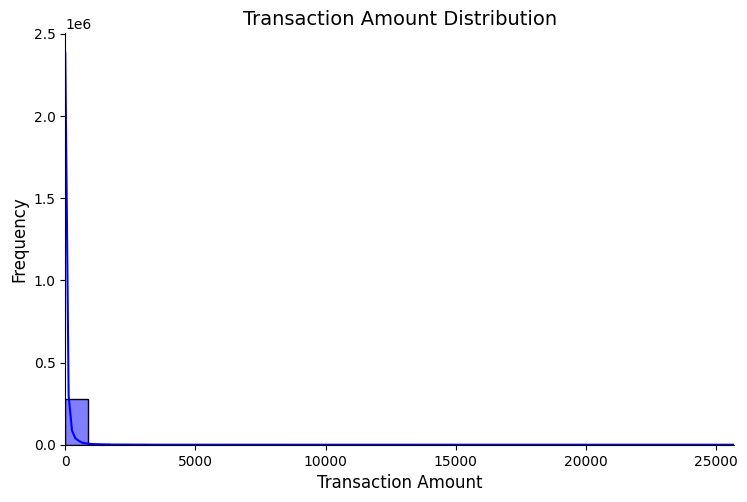

In [23]:
#distribution of transaction 
sns.displot(df['Amount'], kde=True, bins=30, aspect=1.5, color="blue")
plt.xlim(df['Amount'].min(), df['Amount'].max())
plt.title('Transaction Amount Distribution', fontsize=14)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

The distribution is right-skewed, indicates that most transaction amounts are concentrated on the lower end, with a few larger transactions extending the tail to the right. 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


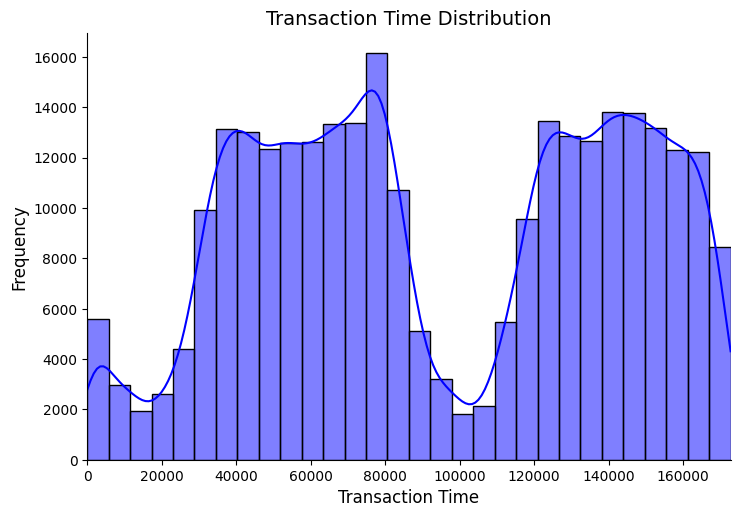

In [24]:
#distribution of transaction time
sns.displot(df['Time'], kde=True, bins=30, aspect=1.5, color="blue")
plt.xlim(df['Time'].min(), df['Time'].max())
plt.title('Transaction Time Distribution', fontsize=14)
plt.xlabel('Transaction Time', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

The distribution is uniform 

In [5]:
#dropping time
df = df.drop(["Time"] , axis = 1)

#### Train Test Split

In [6]:
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

#### Feature Scaling

In [7]:
#scale values: amount and time, rest are scaled
#using robust scaler, since it' robust to outliers (fraud detection has anomalies/outliers)
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
201788,2.023734,-0.429219,-0.691061,-0.201461,-0.162486,0.283718,-0.674694,0.192230,1.124319,-0.037763,...,-0.171390,-0.195207,-0.477813,0.340513,0.059174,-0.431015,-0.297028,-0.000063,-0.046947,-0.345273
179369,-0.145286,0.736735,0.543226,0.892662,0.350846,0.089253,0.626708,-0.049137,-0.732566,0.297692,...,0.206709,-0.124288,-0.263560,-0.110568,-0.434224,-0.509076,0.719784,-0.006357,0.146053,-0.206439
73138,-3.015846,-1.920606,1.229574,0.721577,1.089918,-0.195727,-0.462586,0.919341,-0.612193,-0.966197,...,0.842838,0.274911,-0.319550,0.212891,-0.268792,0.241190,0.318445,-0.100726,-0.365257,0.358043
208679,1.851980,-1.007445,-1.499762,-0.220770,-0.568376,-1.232633,0.248573,-0.539483,-0.813368,0.785431,...,-0.196551,-0.406722,-0.899081,0.137370,0.075894,-0.244027,0.455618,-0.094066,-0.031488,0.362400
206534,2.237844,-0.551513,-1.426515,-0.924369,-0.401734,-1.438232,-0.119942,-0.449263,-0.717258,0.851668,...,-0.045417,0.050447,0.125601,0.215531,-0.080485,-0.063975,-0.307176,-0.042838,-0.063872,-0.316109


In [8]:
#scale the test set
X_test['Amount'] = scaler.transform(X_test[['Amount']])
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
49089,1.229452,-0.235478,-0.627166,0.419877,1.797014,4.069574,-0.896223,1.036103,0.745991,-0.147304,...,-0.057922,-0.170060,-0.288750,-0.130270,1.025935,0.847990,-0.271476,0.060052,0.018104,-0.340485
154704,2.016893,-0.088751,-2.989257,-0.142575,2.675427,3.332289,-0.652336,0.752811,1.962566,-1.025024,...,-0.147619,-0.184153,-0.089661,0.087188,0.570679,0.101899,0.620842,-0.048958,-0.042831,-0.320859
67247,0.535093,-1.469185,0.868279,0.385462,-1.439135,0.368118,-0.499370,0.303698,1.042073,-0.437209,...,0.437685,0.028010,-0.384708,-0.128376,0.286638,-0.136700,0.913904,-0.083364,0.052485,0.853442
251657,2.128486,-0.117215,-1.513910,0.166456,0.359070,-0.540072,0.116023,-0.216140,0.680314,0.079977,...,-0.227278,-0.357993,-0.905085,0.223474,-1.075605,-0.188519,0.267672,-0.071733,-0.072238,-0.344410
201903,0.558593,1.587908,-2.368767,5.124413,2.171788,-0.500419,1.059829,-0.254233,-1.959060,0.948915,...,0.249457,-0.035049,0.271455,0.381606,0.332001,-0.334757,0.448890,0.168585,0.004955,-0.229480


#### Transforming Skewed Features

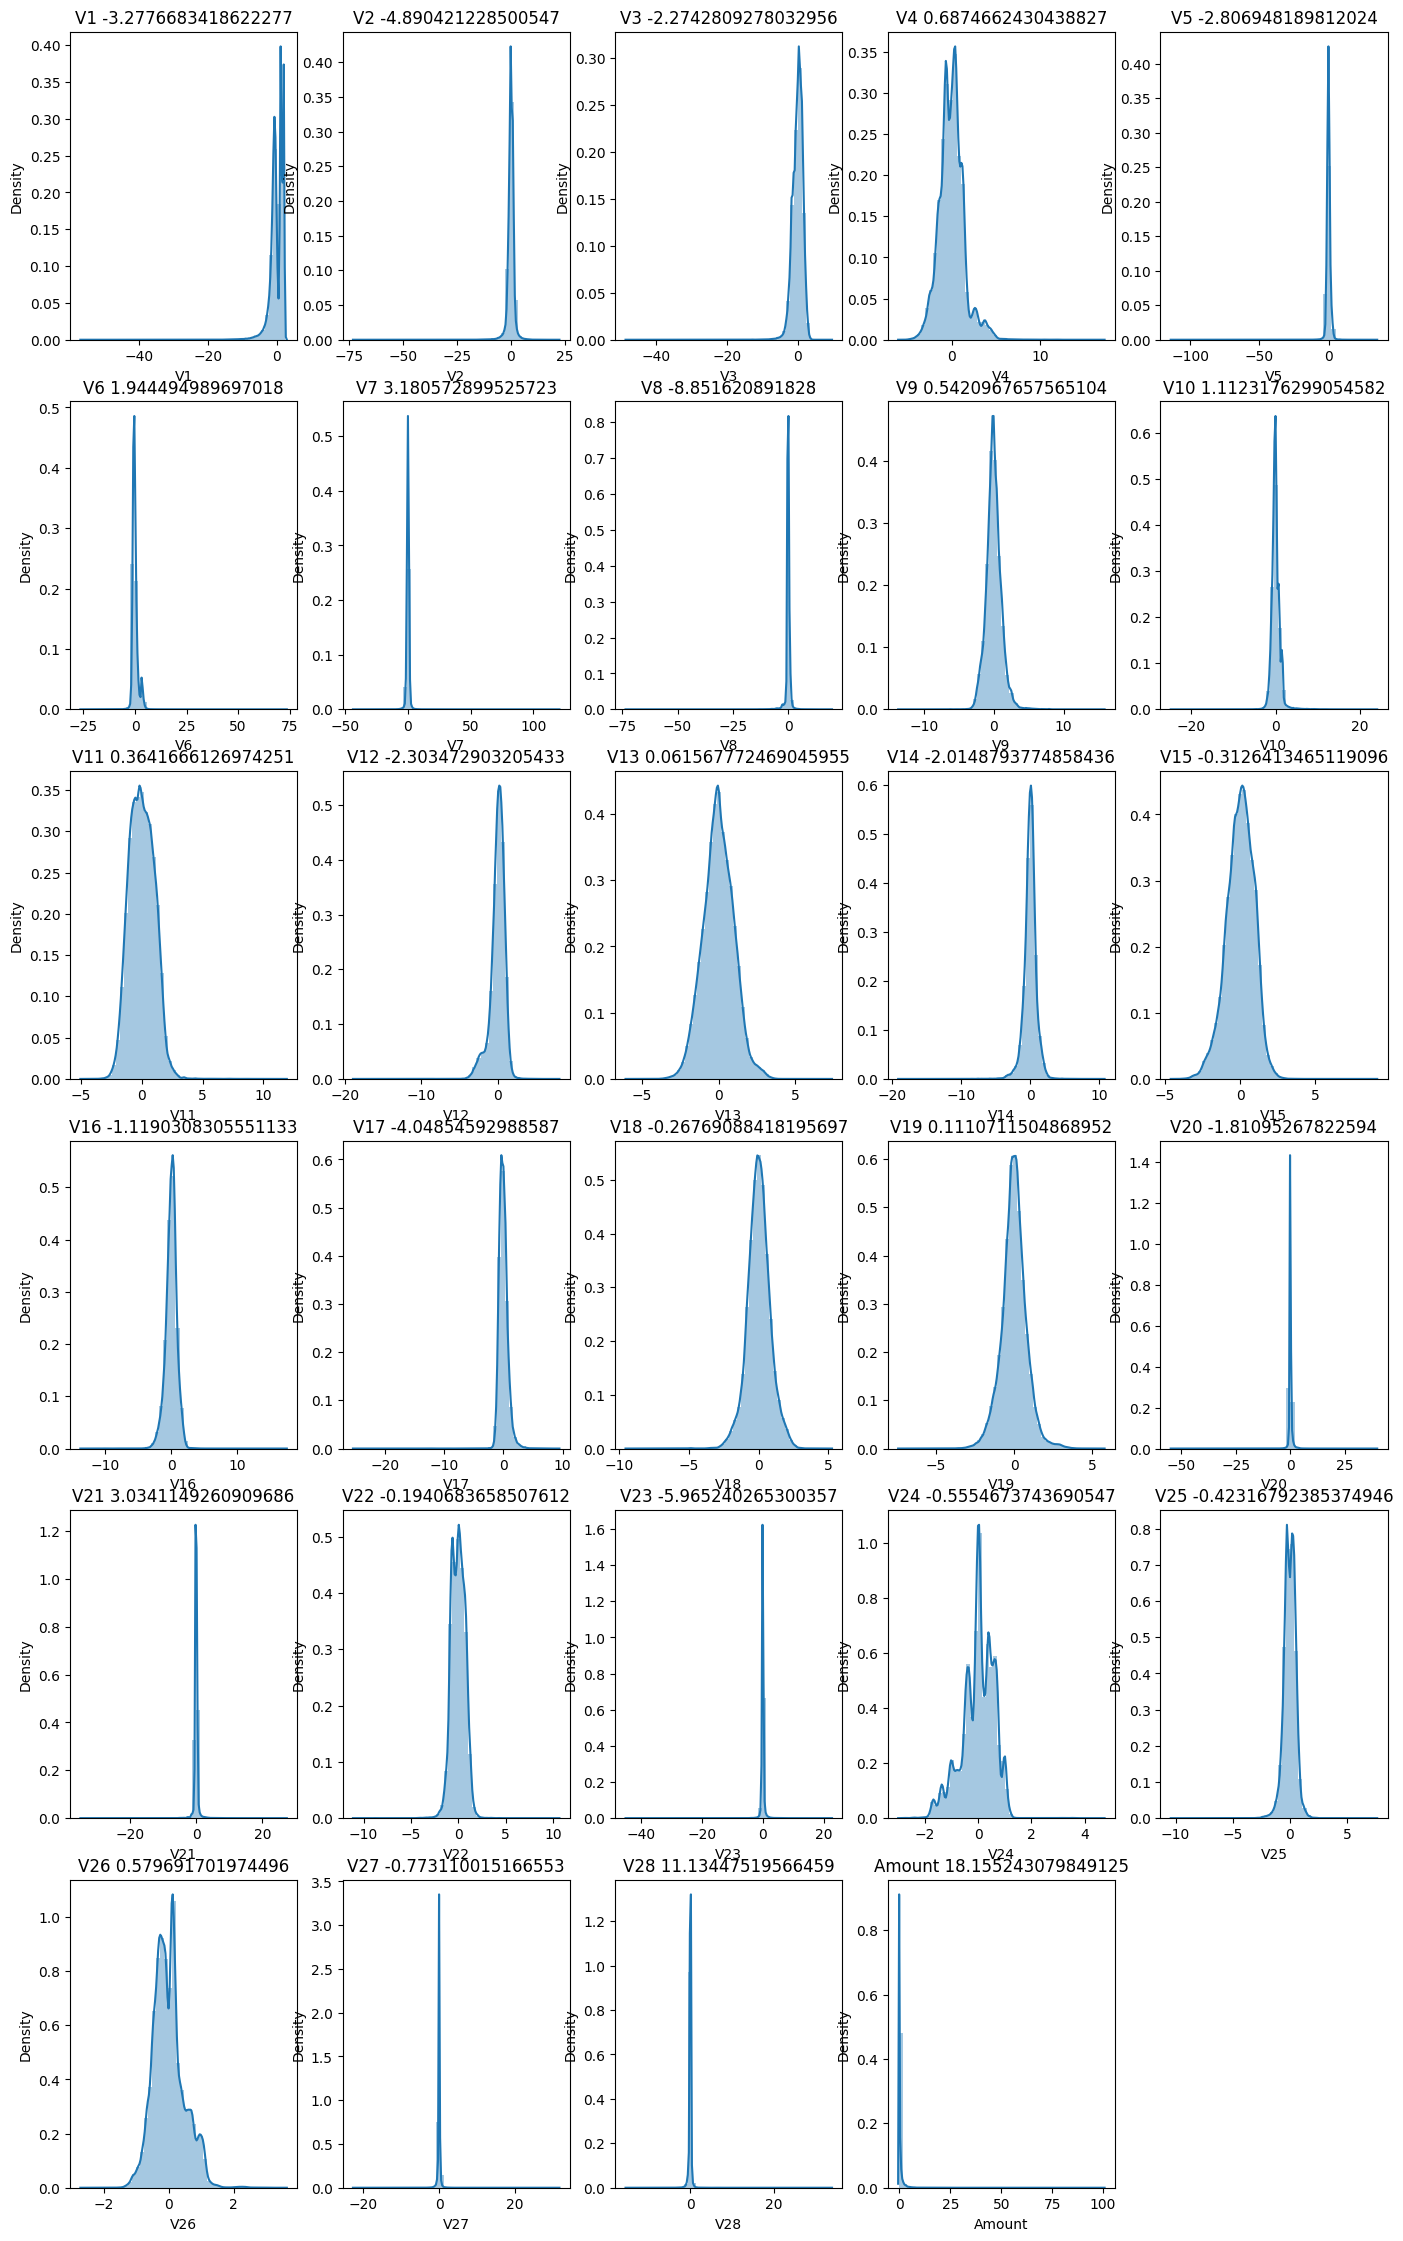

In [10]:
cols = X_train.columns
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

In [11]:
#transform the skewed features
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
#fit and transform the PT on training data
X_train[cols] = pt.fit_transform(X_train)
X_test[cols] = pt.transform(X_test)

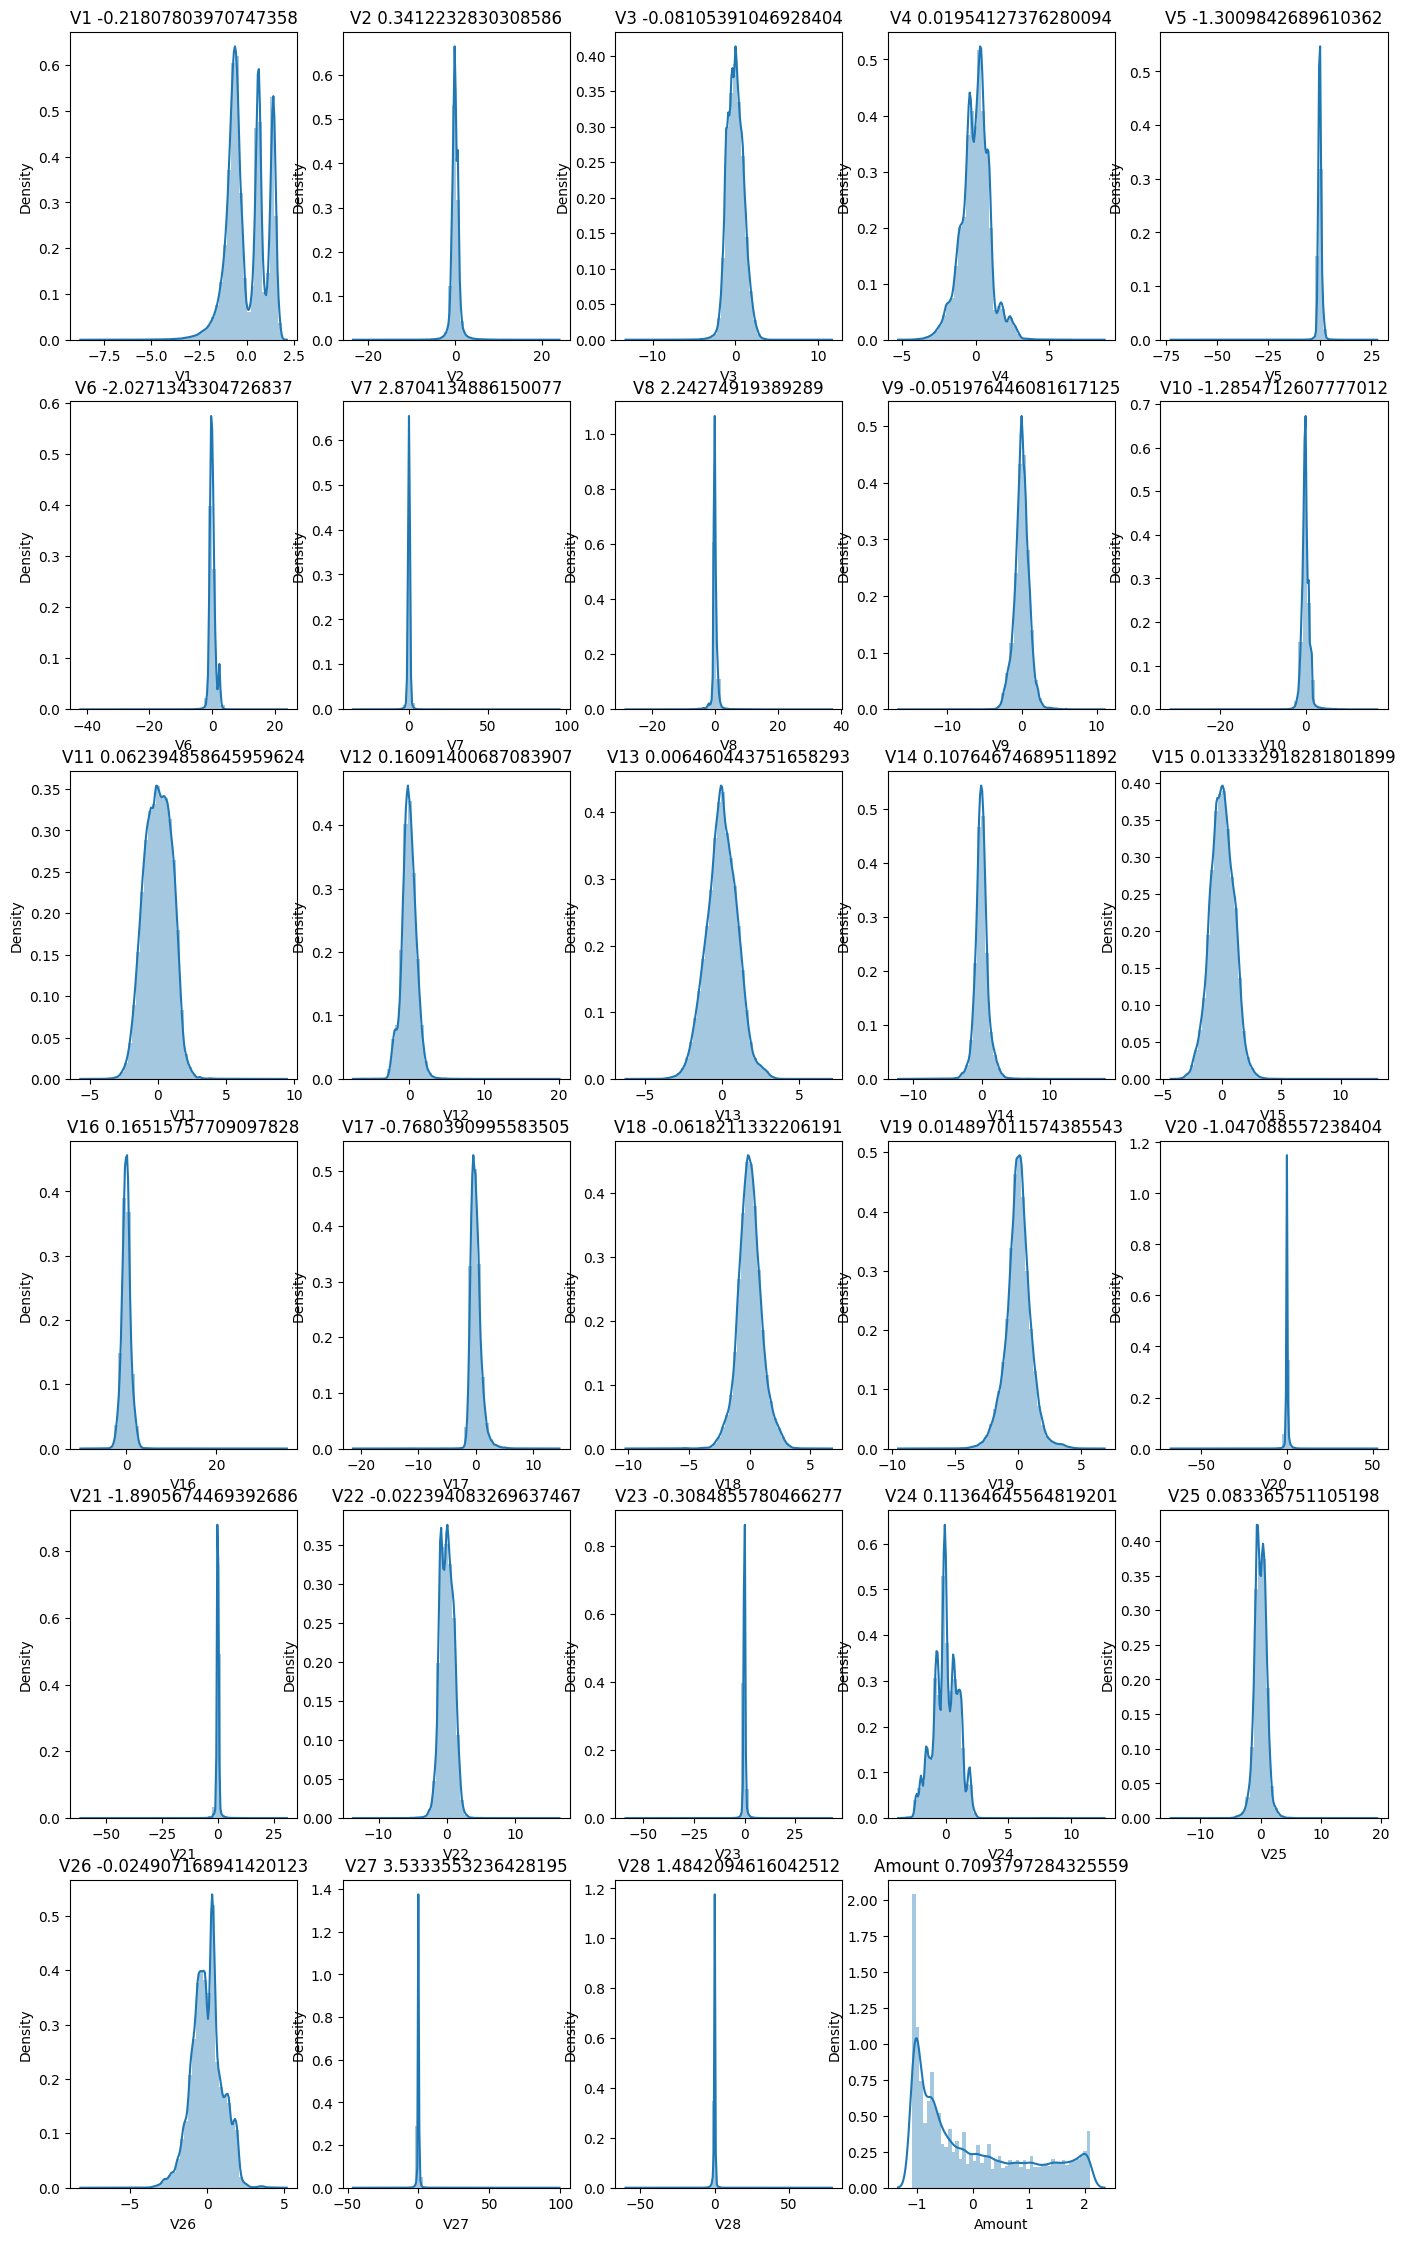

In [49]:
#all the features are normally distributed now
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

#### Class Imbalance: 
1. Random Under Sampling: Reduces the majority class to match the minority class.
2. Random Over Sampling: Increases the minority class by duplicating existing samples until class counts match.
3. Smote: Generates synthetic samples for the minority class using k-nearest neighbors.

#### UnderSampling

In [50]:
rus = RandomUnderSampler()
# resampling X, y
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [51]:
Counter(y_train_rus) , Counter(y_train)

(Counter({0: 396, 1: 396}), Counter({0: 227449, 1: 396}))

#### Building Models

#### Logistic Regression

In [52]:
#lr with grid search cv
folds = KFold(n_splits=5, shuffle=True, random_state=4)
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
model_cv.fit(X_train_rus, y_train_rus)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [53]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']
print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.983311695429611 at C = 0.01


In [57]:
#fit model with best params
logistic_bal_rus = LogisticRegression(C=0.01)
logistic_bal_rus_model = logistic_bal_rus.fit(X_train_rus, y_train_rus)

In [63]:
#predict on train set
y_train_pred = logistic_bal_rus_model.predict(X_train_rus)
print("Confusion Matrix:")
print(confusion_matrix(y_train_rus, y_train_pred))

precision = precision_score(y_train_rus, y_train_pred)
recall = recall_score(y_train_rus, y_train_pred)
f1 = f1_score(y_train_rus, y_train_pred)
y_train_pred_proba = logistic_bal_rus_model.predict_proba(X_train_rus)[:,1]
auc_score = roc_auc_score(y_train_rus, y_train_pred_proba)


print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

print("\nClassification Report:")
print(classification_report(y_train_rus, y_train_pred))

Confusion Matrix:
[[394   2]
 [ 43 353]]
Precision: 0.99
Recall: 0.89
F1-Score: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       396
           1       0.99      0.89      0.94       396

    accuracy                           0.94       792
   macro avg       0.95      0.94      0.94       792
weighted avg       0.95      0.94      0.94       792



In [19]:
#roc_curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

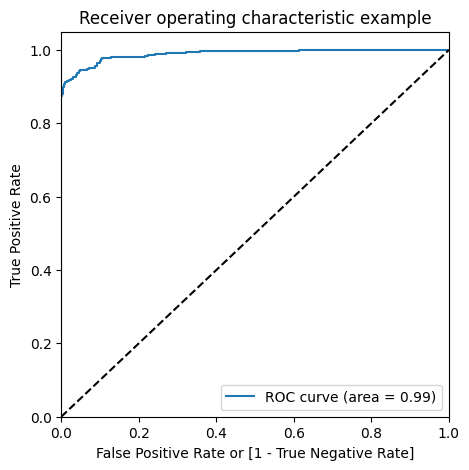

In [68]:
#ROC curve
draw_roc(y_train_rus, y_train_pred_proba)

In [69]:
#predict on test set
y_test_pred = logistic_bal_rus_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_probs = logistic_bal_rus_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_probs)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[56320   546]
 [   17    79]]
Precision: 0.13
Recall: 0.82
F1-Score: 0.22
AUC-ROC-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56866
           1       0.13      0.82      0.22        96

    accuracy                           0.99     56962
   macro avg       0.56      0.91      0.61     56962
weighted avg       1.00      0.99      0.99     56962



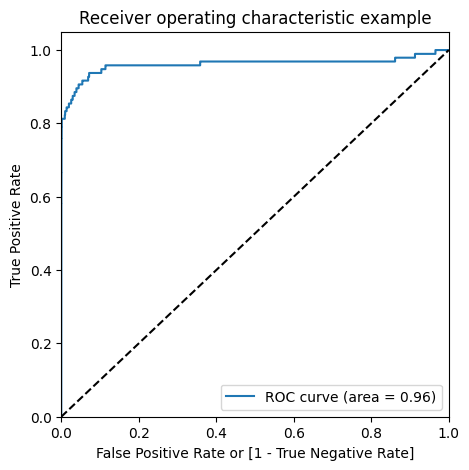

In [71]:
#ROC curve
draw_roc(y_test, y_test_pred_proba)

#### XGBoost

In [84]:
folds = 3
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)
#GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      
#fit the model
model_cv.fit(X_train_rus, y_train_rus)   

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [85]:
model_cv.best_params_

{'learning_rate': 0.2, 'subsample': 0.6}

In [86]:
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

#fit model on training data
xgb_rus_model = XGBClassifier(params = params)
xgb_rus_model.fit(X_train_rus, y_train_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6}, ...)

In [95]:
#predict on train 
y_train_pred = xgb_rus_model.predict(X_train_rus)
print("Confusion Matrix:")
print(confusion_matrix(y_train_rus, y_train_pred))

precision = precision_score(y_train_rus, y_train_pred)
recall = recall_score(y_train_rus, y_train_pred)
f1 = f1_score(y_train_rus, y_train_pred)
y_train_pred_proba = xgb_rus_model.predict_proba(X_train_rus)[:,1]
auc_score = roc_auc_score(y_train_rus, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_train_rus, y_train_pred))

Confusion Matrix:
[[396   0]
 [  0 396]]
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC-Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       396
           1       1.00      1.00      1.00       396

    accuracy                           1.00       792
   macro avg       1.00      1.00      1.00       792
weighted avg       1.00      1.00      1.00       792



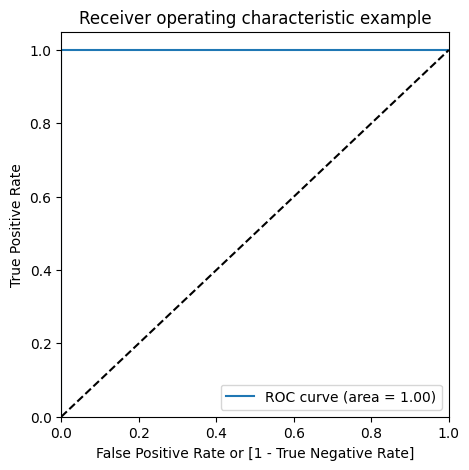

In [97]:
#ROC curve
draw_roc(y_train_rus, y_train_pred_proba)

In [92]:
#predict on test set
y_test_pred = xgb_rus_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = xgb_rus_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[54684  2182]
 [    8    88]]
Precision: 0.04
Recall: 0.92
F1-Score: 0.07
AUC-ROC-Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56866
           1       0.04      0.92      0.07        96

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



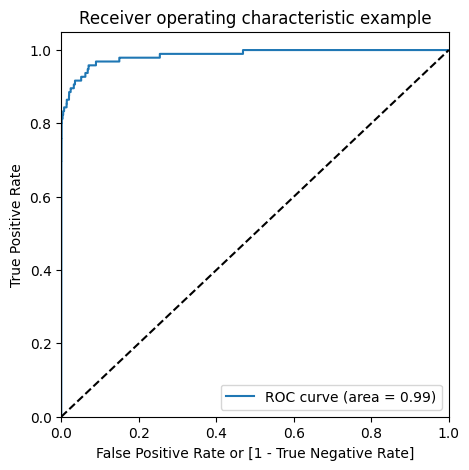

In [93]:
#ROC curve
draw_roc(y_test, y_test_pred_proba)

#### Decision Tree

In [98]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

#Fit the grid search to the data
grid_search.fit(X_train_rus,y_train_rus)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [99]:
print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9660047444138353
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100)


In [100]:
dt_rus_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_rus_model.fit(X_train_rus, y_train_rus)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

In [101]:
#predict on train 
y_train_pred = dt_rus_model.predict(X_train_rus)
print("Confusion Matrix:")
print(confusion_matrix(y_train_rus, y_train_pred))

precision = precision_score(y_train_rus, y_train_pred)
recall = recall_score(y_train_rus, y_train_pred)
f1 = f1_score(y_train_rus, y_train_pred)
y_train_pred_proba = dt_rus_model.predict_proba(X_train_rus)[:,1]
auc_score = roc_auc_score(y_train_rus, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_train_rus, y_train_pred))

Confusion Matrix:
[[386  10]
 [ 45 351]]
Precision: 0.97
Recall: 0.89
F1-Score: 0.93
AUC-ROC-Score: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       396
           1       0.97      0.89      0.93       396

    accuracy                           0.93       792
   macro avg       0.93      0.93      0.93       792
weighted avg       0.93      0.93      0.93       792



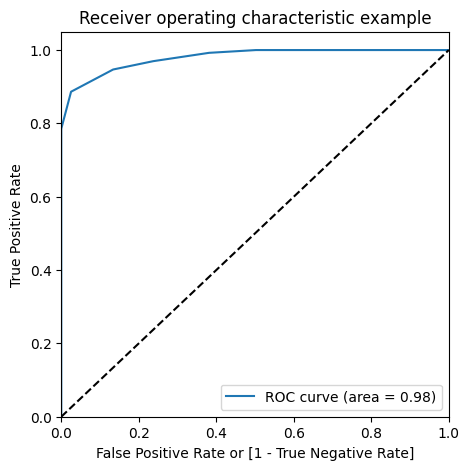

In [105]:
#ROC curve
draw_roc(y_train_rus, y_train_pred_proba)

In [103]:
#predict on test set
y_test_pred = dt_rus_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = dt_rus_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[54523  2343]
 [   14    82]]
Precision: 0.03
Recall: 0.85
F1-Score: 0.07
AUC-ROC-Score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56866
           1       0.03      0.85      0.07        96

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.52     56962
weighted avg       1.00      0.96      0.98     56962



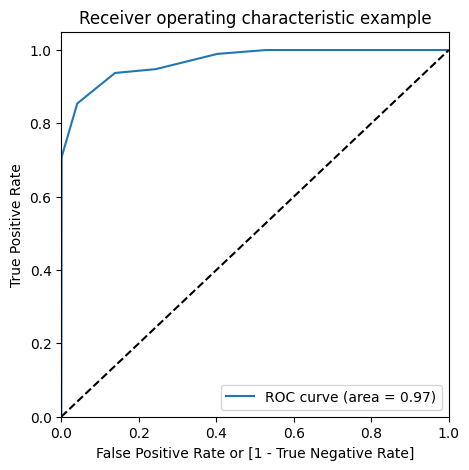

In [104]:
#ROC curve
draw_roc(y_test, y_test_pred_proba)

#### OVERSAMPLING

In [108]:
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [109]:
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_ros))

Before sampling class distribution:- Counter({0: 227449, 1: 396})
New class distribution:- Counter({0: 227449, 1: 227449})


#### Logistic Regression

In [110]:
folds = KFold(n_splits=5, shuffle=True, random_state=4)
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
model_cv.fit(X_train_ros, y_train_ros)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [111]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']
print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.9886467362512746 at C = 0.1


In [114]:
logistic_ros = LogisticRegression(C=0.1)
logistic_ros_model = logistic_ros.fit(X_train_ros, y_train_ros)

In [118]:
y_train_pred = logistic_ros_model .predict(X_train_ros)
print("Confusion Matrix:")
print(confusion_matrix(y_train_ros, y_train_pred))

precision = precision_score(y_train_ros, y_train_pred)
recall = recall_score(y_train_ros, y_train_pred)
f1 = f1_score(y_train_ros, y_train_pred)
y_train_pred_proba = logistic_ros_model.predict_proba(X_train_ros)[:,1]
auc_score = roc_auc_score(y_train_ros, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_train_ros, y_train_pred))

Confusion Matrix:
[[222271   5178]
 [ 17606 209843]]
Precision: 0.98
Recall: 0.92
F1-Score: 0.95
AUC-ROC-Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    227449
           1       0.98      0.92      0.95    227449

    accuracy                           0.95    454898
   macro avg       0.95      0.95      0.95    454898
weighted avg       0.95      0.95      0.95    454898



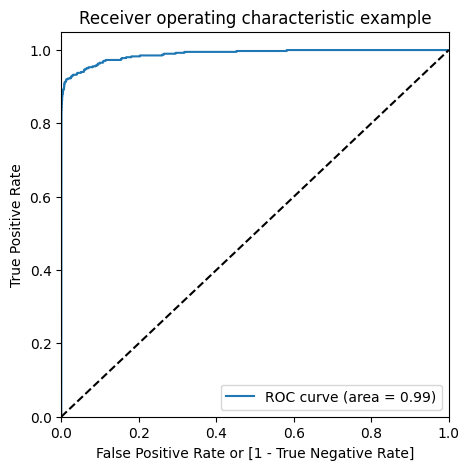

In [119]:
#ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

Confusion Matrix:
[[55532  1334]
 [   11    85]]
Precision: 0.06
Recall: 0.89
F1-Score: 0.11
AUC-ROC-Score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.06      0.89      0.11        96

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



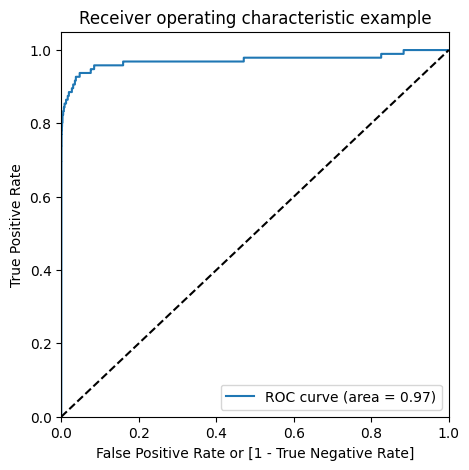

In [120]:
#predict on test set
y_test_pred = logistic_ros_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = logistic_ros_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

#ROC Curve
draw_roc(y_test, y_test_pred_proba)


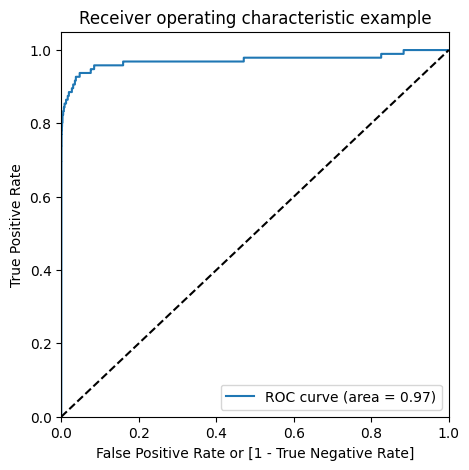

In [121]:
draw_roc(y_test, y_test_pred_proba)

#### XGBoost

In [122]:
folds = 3
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      
model_cv.fit(X_train_ros, y_train_ros)     

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [123]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.6}

In [124]:
#chosen hyperparameters
params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xgb_ros_model = XGBClassifier(params = params)
xgb_ros_model.fit(X_train_ros, y_train_ros)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6}, ...)

In [125]:
#predict on train 
y_train_pred = xgb_ros_model.predict(X_train_ros)
print("Confusion Matrix:")
print(confusion_matrix(y_train_ros, y_train_pred))

precision = precision_score(y_train_ros, y_train_pred)
recall = recall_score(y_train_ros, y_train_pred)
f1 = f1_score(y_train_ros, y_train_pred)
y_train_pred_proba = xgb_ros_model.predict_proba(X_train_ros)[:,1]
auc_score = roc_auc_score(y_train_ros, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_train_ros, y_train_pred))

Confusion Matrix:
[[227449      0]
 [     0 227449]]
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC-Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227449
           1       1.00      1.00      1.00    227449

    accuracy                           1.00    454898
   macro avg       1.00      1.00      1.00    454898
weighted avg       1.00      1.00      1.00    454898



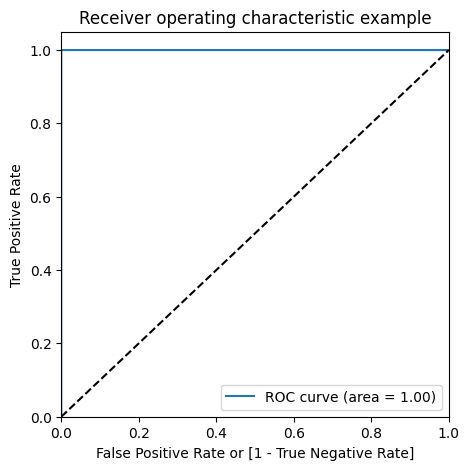

In [126]:
#ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

In [127]:
#predict on test set
y_test_pred = xgb_ros_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = xgb_ros_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[56855    11]
 [   23    73]]
Precision: 0.87
Recall: 0.76
F1-Score: 0.81
AUC-ROC-Score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.87      0.76      0.81        96

    accuracy                           1.00     56962
   macro avg       0.93      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962



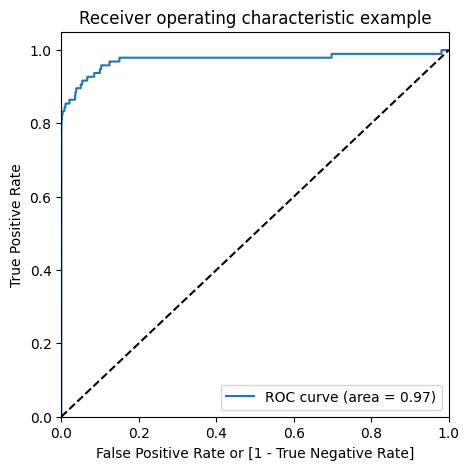

In [128]:
#ROC Curve
draw_roc(y_test, y_test_pred_proba)

#### Decision Tree

In [129]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)
grid_search.fit(X_train_ros,y_train_ros)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [130]:
print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9996130301468256
DecisionTreeClassifier(max_depth=10, min_samples_leaf=100,
                       min_samples_split=100)


In [131]:
dt_ros_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=100,
                                  min_samples_split=50)

dt_ros_model.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, min_samples_split=50,
                       random_state=100)

In [132]:
#predict on train 
y_train_pred = dt_ros_model.predict(X_train_ros)
print("Confusion Matrix:")
print(confusion_matrix(y_train_ros, y_train_pred))

precision = precision_score(y_train_ros, y_train_pred)
recall = recall_score(y_train_ros, y_train_pred)
f1 = f1_score(y_train_ros, y_train_pred)
y_train_pred_proba = dt_ros_model.predict_proba(X_train_ros)[:,1]
auc_score = roc_auc_score(y_train_ros, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_train_ros, y_train_pred))

Confusion Matrix:
[[225919   1530]
 [     0 227449]]
Precision: 0.99
Recall: 1.00
F1-Score: 1.00
AUC-ROC-Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    227449
           1       0.99      1.00      1.00    227449

    accuracy                           1.00    454898
   macro avg       1.00      1.00      1.00    454898
weighted avg       1.00      1.00      1.00    454898



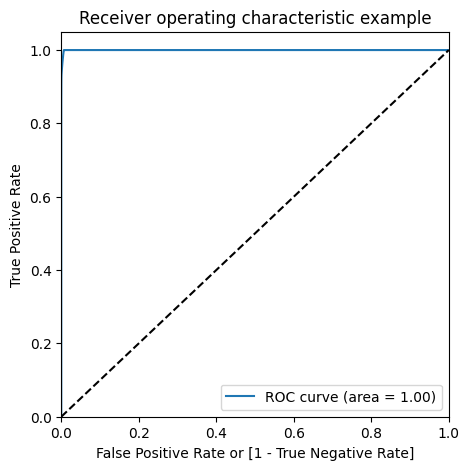

In [133]:
#ROC curve
draw_roc(y_train_ros, y_train_pred_proba)

Confusion Matrix:
[[56436   430]
 [   20    76]]
Precision: 0.15
Recall: 0.79
F1-Score: 0.25
AUC-ROC-Score: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56866
           1       0.15      0.79      0.25        96

    accuracy                           0.99     56962
   macro avg       0.57      0.89      0.62     56962
weighted avg       1.00      0.99      0.99     56962



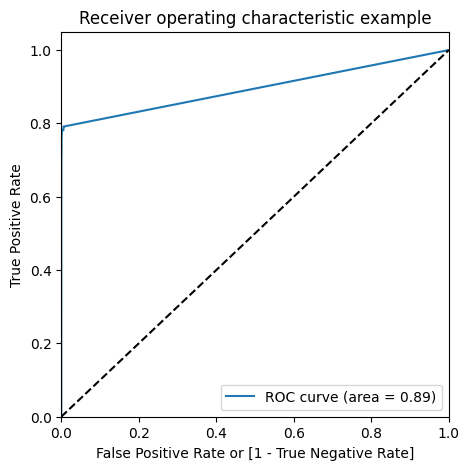

In [134]:
#predict on test set
y_test_pred = dt_ros_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = dt_ros_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

#ROC Curve
draw_roc(y_test, y_test_pred_proba)


#### SMOTE (Synthetic Minority Oversampling Technique)

In [12]:
sm = SMOTE(random_state=27)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [13]:
print('Before SMOTE oversampling X_train shape=',X_train.shape)
print('After SMOTE oversampling X_train shape=',X_train_smote.shape)

Before SMOTE oversampling X_train shape= (227845, 29)
After SMOTE oversampling X_train shape= (454898, 29)


#### Logistic Regression


In [14]:
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as roc-auc
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [15]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']
print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.9897409900830768 at C = 0.1


In [16]:
logistic_smote = LogisticRegression(C=0.1)
logistic_smote_model = logistic_smote.fit(X_train_smote, y_train_smote)

In [17]:
#predict on train 
y_train_pred = logistic_smote_model.predict(X_train_smote)
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote, y_train_pred))

precision = precision_score(y_train_smote, y_train_pred)
recall = recall_score(y_train_smote, y_train_pred)
f1 = f1_score(y_train_smote, y_train_pred)
y_train_pred_proba = logistic_smote_model.predict_proba(X_train_smote)[:,1]
auc_score = roc_auc_score(y_train_smote, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")
print("\nClassification Report:")
print(classification_report(y_train_smote, y_train_pred))

Confusion Matrix:
[[221911   5538]
 [ 17693 209756]]
Precision: 0.97
Recall: 0.92
F1-Score: 0.95
AUC-ROC-Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    227449
           1       0.97      0.92      0.95    227449

    accuracy                           0.95    454898
   macro avg       0.95      0.95      0.95    454898
weighted avg       0.95      0.95      0.95    454898



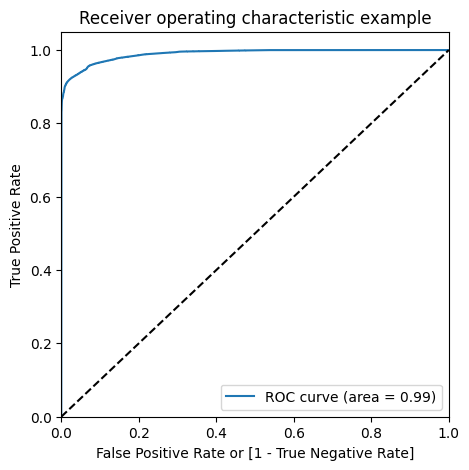

In [20]:
#ROC curve
draw_roc(y_train_smote, y_train_pred_proba)

In [21]:
#predict on test set
y_test_pred = logistic_smote_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = logistic_smote_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[55416  1450]
 [   10    86]]
Precision: 0.06
Recall: 0.90
F1-Score: 0.11
AUC-ROC-Score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56866
           1       0.06      0.90      0.11        96

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



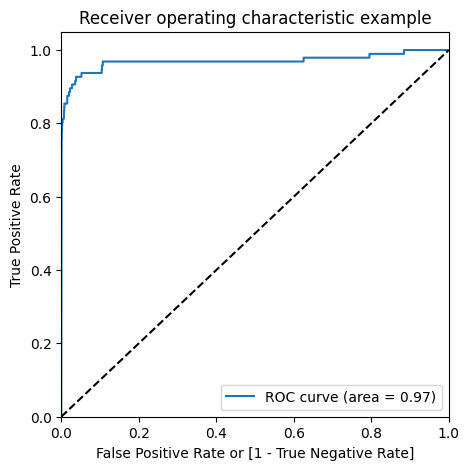

In [22]:
#ROC Curve
draw_roc(y_test, y_test_pred_proba)

#### XGBoost

In [23]:
folds = 3
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(X_train_smote, y_train_smote)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [24]:
model_cv.best_params_

{'learning_rate': 0.6, 'subsample': 0.6}

In [25]:
params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

xgb_smote_model = XGBClassifier(params = params)
xgb_smote_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6}, ...)

In [27]:
#predict on train set
y_train_pred = xgb_smote_model.predict(X_train_smote)
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote, y_train_pred))

precision = precision_score(y_train_smote, y_train_pred)
recall = recall_score(y_train_smote, y_train_pred)
f1 = f1_score(y_train_smote, y_train_pred)
y_train_pred_proba = xgb_smote_model.predict_proba(X_train_smote)[:,1]
auc_score = roc_auc_score(y_train_smote, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")
print("\nClassification Report:")
print(classification_report(y_train_smote, y_train_pred))

Confusion Matrix:
[[227448      1]
 [     0 227449]]
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC-Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227449
           1       1.00      1.00      1.00    227449

    accuracy                           1.00    454898
   macro avg       1.00      1.00      1.00    454898
weighted avg       1.00      1.00      1.00    454898



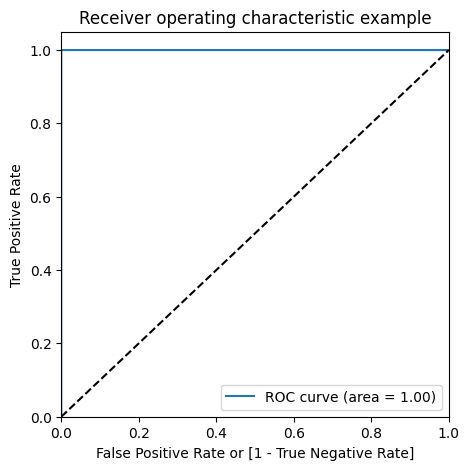

In [28]:
#ROC curve
draw_roc(y_train_smote, y_train_pred_proba)

In [29]:
#predict on test set
y_test_pred = xgb_smote_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = xgb_smote_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[56833    33]
 [   20    76]]
Precision: 0.70
Recall: 0.79
F1-Score: 0.74
AUC-ROC-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.70      0.79      0.74        96

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962



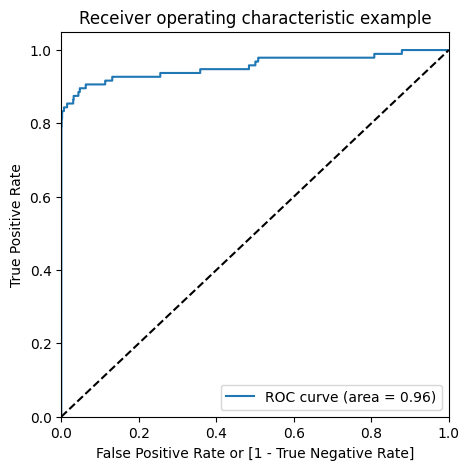

In [30]:
#ROC Curve
draw_roc(y_test, y_test_pred_proba)

#### Decision Tree

In [31]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

grid_search.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [32]:
print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9980766164122006
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100)


In [33]:
dt_smote_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
dt_smote_model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100,
                       random_state=100)

In [35]:
#predict on train set
y_train_pred = dt_smote_model.predict(X_train_smote)
print("Confusion Matrix:")
print(confusion_matrix(y_train_smote, y_train_pred))

precision = precision_score(y_train_smote, y_train_pred)
recall = recall_score(y_train_smote, y_train_pred)
f1 = f1_score(y_train_smote, y_train_pred)
y_train_pred_proba = dt_smote_model.predict_proba(X_train_smote)[:,1]
auc_score = roc_auc_score(y_train_smote, y_train_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")
print("\nClassification Report:")
print(classification_report(y_train_smote, y_train_pred))

Confusion Matrix:
[[223809   3640]
 [  2374 225075]]
Precision: 0.98
Recall: 0.99
F1-Score: 0.99
AUC-ROC-Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    227449
           1       0.98      0.99      0.99    227449

    accuracy                           0.99    454898
   macro avg       0.99      0.99      0.99    454898
weighted avg       0.99      0.99      0.99    454898



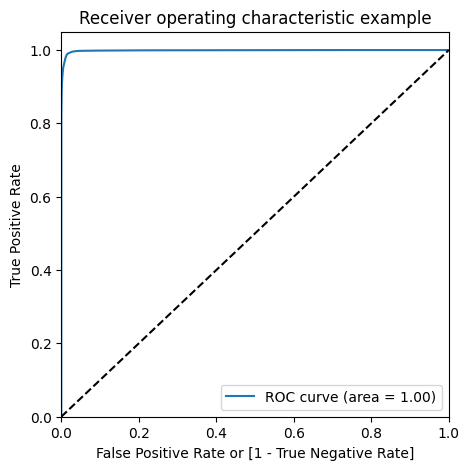

In [36]:
#ROC curve
draw_roc(y_train_smote, y_train_pred_proba)

In [37]:
#predict on test set
y_test_pred = dt_smote_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_pred_proba = dt_smote_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[55852  1014]
 [   19    77]]
Precision: 0.07
Recall: 0.80
F1-Score: 0.13
AUC-ROC-Score: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.07      0.80      0.13        96

    accuracy                           0.98     56962
   macro avg       0.54      0.89      0.56     56962
weighted avg       1.00      0.98      0.99     56962



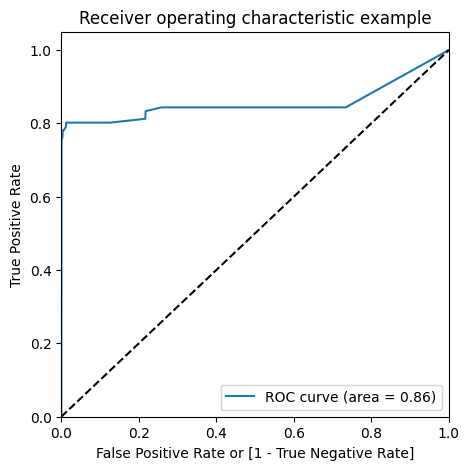

In [38]:
#ROC Curve
draw_roc(y_test, y_test_pred_proba)

#### Summary:
Data Preprocessing:
1. Analyzing Variation: variation of features (Time and Amount) with respect to the Class (Fraud/Non-Fraud).
2. Dropping Time:it may not directly contribute to fraud detection.
3. Scaling Features:Applied StandardScaler to normalize Amount and other features to ensure consistent scale.
4. Transforming Skewed Features:Used PowerTransformer to address skewness and make feature distributions more normal.
   
Modeling and Addressing Class Imbalance Techniques:
1. Random Undersampling (RUS): Reduced the majority class to match the minority class.
2. Random Oversampling (ROS): Duplicated samples from the minority class to balance the dataset.
3. SMOTE: Applied Synthetic Minority Oversampling Technique to generate synthetic samples for the minority class.

Model Performance:
ROC-AUC Score on Unsampled Test Set 
1. Random Undersampling (RUS):
    - Logistic Regression: 0.96
    - XGBoost: 0.99
    - Decision Tree: 0.97
2. Random Oversampling (ROS):
    - Logistic Regression: 0.97
    - XGBoost: 0.97
    - Decision Tree: 0.89
3. SMOTE Sampling:
    - Logistic Regression: 0.97
    - XGBoost: 0.96
    - Decision Tree: 0.86


Inference:

- Undersampling: significantly reduces the amount of training data and can lead to overfitting,
- Logistic Regression showed promising results with SMOTE, 

In [46]:
y_train_pred = logistic_smote_model.predict(X_train_smote)
print('Train auc =', roc_auc_score(y_train_smote, y_train_pred_proba))
fpr, tpr, thresholds = roc_curve(y_train_smote, y_train_pred_proba)
threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold=",threshold)

Train auc = 0.9986355757920081
Threshold= 0.5166666666666667


- The AUC score indicates how well the model distinguishes between fraudulent and non-fraudulent transactions.
A score of 0.9986 implies that the model performs exceptionally well on the training data, with near-perfect classification.

- Threshold value of 0.51 is determined by maximizing the difference between the True Positive Rate (TPR) and False Positive Rate (FPR).
  This threshold is crucial for deciding whether a transaction is classified as fraudulent or non-fraudulent.


In [50]:
#predict on train 
y_train_pred = logistic_smote_model.predict(X_train_smote)
print(classification_report(y_train_smote, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95    227449
           1       0.97      0.92      0.95    227449

    accuracy                           0.95    454898
   macro avg       0.95      0.95      0.95    454898
weighted avg       0.95      0.95      0.95    454898



Bank Perspective:
- For lower amounts: high precision because we only want to label relevant transactions as fraud.
- For higher amounts: high recall in order to detect actual fraud transactions.

Logistic Regression is a solid choice for this fraud detection problem, as it achieves a good balance between performance (ROC-AUC) and interpretability.
Its high recall, especially after applying SMOTE for balancing the dataset, aligns well with the goal of catching fraudulent transactions, even if it means having a few more false positives.